In [1]:
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt

## Loading of datasets to pandas Dataframes

In [2]:
pagename = 'Swine influenza'
filename = 'swineflu'

#### Loading of Wikipedia

In [3]:
try:
    with open('{filename}/{filename}_wikipedia.json'.format(filename=filename), 'r') as file:
        wikipedia_dict = json.load(file)

        dates = [item['timestamp'] for item in wikipedia_dict['items']]
        views = [item['views'] for item in wikipedia_dict['items']]

        wikipedia_df = pd.DataFrame({'Date': dates, 'Views': views})
        wikipedia_df['Date'] = pd.to_datetime(wikipedia_df['Date'], format='%Y%m%d00')
        wikipedia_df['Week'] = wikipedia_df['Date'] - pd.to_timedelta((wikipedia_df['Date'].dt.dayofweek+1) % 7, unit='D')
        weekly_wikipedia_df = wikipedia_df.groupby('Week').apply(lambda x: x.Views.sum()).reset_index(name='Views').set_index('Week')

        wikipedia_df.set_index('Date', inplace=True)
except EnvironmentError: 
    print('Something went wrong in the processing of wikipedia series')


#### Loading of Google Trends

In [4]:
trend_data = []
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

with open('{filename}/{filename}_googletrends.json'.format(filename=filename), 'r') as file:
    gtrends_dict = json.load(file)

    dates = []
    views = [int(data['values'][0]['value']) for data in gtrends_dict['interest_over_time']['timeline_data']]

    for data in gtrends_dict['interest_over_time']['timeline_data']:
        parts = data['date'].replace('–', ' '). replace(',', ' ').split()    
        dates.append(datetime(year=int(parts[2 if len(parts) == 6 else -1]), 
                                   month=month_mapping[parts[0]], 
                                   day=int(parts[1])))
    
    gtrends_df = pd.DataFrame({'Date': dates, 'Views': views})
    gtrends_df.set_index('Date', inplace=True)

## Visualization of the two dataframes on the same plot

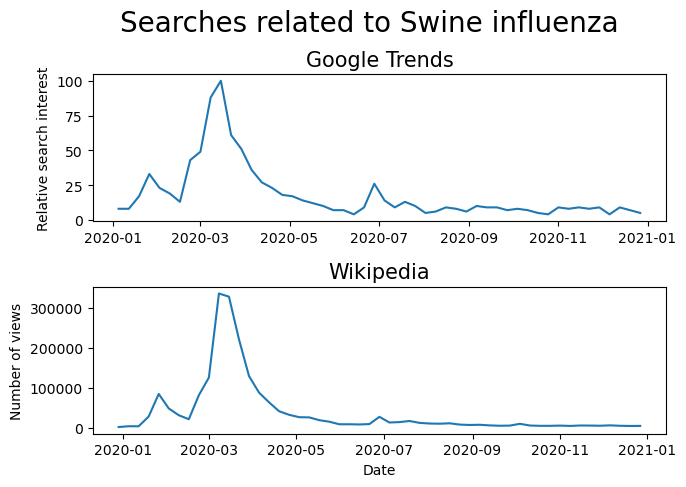

In [5]:
fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(7,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_df['Views'])

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views')
axis[1].plot(weekly_wikipedia_df['Views'])
axis[1].set_xlabel('Date')

plt.show()